## LSTM Model for Generating Pro-Brexit Tweets
#### Franciszek Michałowski

Dataset:
https://www.kaggle.com/datasets/visalakshiiyer/twitter-data-brexit/data?select=TweetDataset_ProBrexit_Jan-Mar2022.csv

The goal of the project is to create a recurrent neural network (LSTM) that will generate tweets supporting Brexit based on a dataset of pro-Brexit tweets from January to March 2022. A word-level LSTM model will be used for this purpose.

Due to the broader availability of materials on building LSTM recurrent neural networks in Python, it was decided to work in this language (Python 3.9).

#### Data Loading

We begin the work by loading the libraries. The required modules are: pandas, numpy, os, matplotlib, nltk, scikit-learn, and bson.

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import random


import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from collections import Counter
from nltk.util import ngrams
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

The dataset we are using comes from Kaggle and contains tweets related to Brexit from the period between January and March 2022. This data includes various information, such as tweet content, publication dates, and user metadata.

The dataset consists of tweets that have been classified as supporting Brexit, giving us the opportunity to analyze specific narratives used by Brexit supporters. This data will serve as the basis for training an LSTM model, which will generate new tweets based on it.

In [2]:
brexit_tweets = pd.read_csv('TweetDataset_ProBrexit_Jan-Mar2022.csv')
brexit_tweets

,Unnamed: 0,Date,Headline,URL,Opening Text,Hit Sentence,Source,Influencer,Country,Subregion,...,Twitter Screen Name,User Profile Url,Twitter Bio,Twitter Followers,Twitter Following,Alternate Date Format,Time,State,City,Document Tags
0,0,15-Jan-2022 11:58PM,NaN,https://twitter.com/dianemcgregor8/statuses/14...,NaN,RT @re11ddy: QT @sandieshoes: Do this if you v...,Twitter,@dianemcgregor8,Cameroon,NaN,...,Diane M McGregor,https://twitter.com/dianemcgregor8,Veggie burger! Lover of all Animals and Nature...,122.0,185.0,"Jan 15, 2022",11:58 PM,North,NaN,NaN
1,1,15-Jan-2022 11:57PM,NaN,http://twitter.com/DeniseMembery/statuses/1482...,NaN,RT @RickSacrop: Michael Fabricant is absolutel...,Twitter,@DeniseMembery,United Kingdom,NaN,...,Denise M.,http://www.twitter.com/DeniseMembery,"🇬🇧✡️ Proud to be British. 🇬🇧 Animal lover, m...",5721.0,6291.0,"Jan 15, 2022",11:57 PM,England,NaN,NaN
2,2,15-Jan-2022 11:56PM,NaN,https://twitter.com/007Stirling/statuses/14825...,NaN,@StokieDrew2 I do find it rich; that Tory vote...,Twitter,@007stirling,United Kingdom,NaN,...,Finlay Stirling 🇬🇧☘️❤️🏴󠁧󠁢󠁳󠁣󠁴󠁿,https://twitter.com/007Stirling,BRITISH/IRISH/ULSTER-SCOTS PUL\nRIGHT-WING. \n...,7219.0,7433.0,"Jan 15, 2022",11:56 PM,Northern Ireland,Belfast,NaN
3,3,15-Jan-2022 11:54PM,NaN,https://twitter.com/UKleadstheworld/statuses/1...,NaN,RT @denistmurray: Brexit Britain win as London...,Twitter,@ukleadstheworld,United Kingdom,NaN,...,BestofBritish,https://twitter.com/UKleadstheworld,"GB News, Conservatives, Brexiteer, Block all ads.",700.0,1014.0,"Jan 15, 2022",11:54 PM,NaN,NaN,NaN
4,4,15-Jan-2022 11:53PM,NaN,https://twitter.com/paul_beamish/statuses/1482...,NaN,@afneil If Johnson is taken down by The Tories...,Twitter,@paul_beamish,United Kingdom,NaN,...,Paul Beamish,https://twitter.com/paul_beamish,Brexiteer and Shipbuilder (Plater/Welder) livi...,200.0,822.0,"Jan 15, 2022",11:53 PM,England,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147626,16131,20-Mar-2022 12:01AM,NaN,http://twitter.com/Brexiteer1234/statuses/1505...,NaN,@JamesRobvincent @7nestingwrens He was also fi...,Twitter,@Brexiteer1234,United Kingdom,NaN,...,Wendy🇬🇧,http://www.twitter.com/Brexiteer1234,Conservative/Brexiteer. Boris is not perfect b...,813.0,892.0,"Mar 20, 2022",12:01 AM,England,Lichfield,NaN
147627,16132,20-Mar-2022 12:00AM,NaN,https://twitter.com/Georgin40427121/statuses/1...,NaN,RT @sandieshoes: Boris is being heavily critic...,Twitter,@georgin40427121,United States,NaN,...,Georgina,https://twitter.com/Georgin40427121,"http://Brexiteer.support Boris,Love our countr...",662.0,228.0,"Mar 20, 2022",12:00 AM,Pennsylvania,Bristol,NaN
147628,16133,20-Mar-2022 12:00AM,NaN,https://twitter.com/sandieshoes/statuses/15053...,NaN,Ludicrous to suggest Boris is insulting Ukrain...,Twitter,@sandieshoes,Unknown,NaN,...,sandieshoes 🇬🇧🇺🇸,https://twitter.com/sandieshoes,Brexiteer🇬🇧Animal lover. Where did that opini...,23594.0,23015.0,"Mar 20, 2022",12:00 AM,NaN,NaN,NaN
147629,16134,20-Mar-2022 12:00AM,NaN,http://twitter.com/Sunpoches/statuses/15053333...,NaN,RT @DannyInvictus: @timfarron @ThomasEvansAdur...,Twitter,@Sunpoches,United Kingdom,NaN,...,Free at Last,http://www.twitter.com/Sunpoches,52% Pro Brexit: 48% Anti EU #ManagedNoDeal - W...,4589.0,5035.0,"Mar 20, 2022",12:00 AM,England,London,NaN


### Data preparation

The 'Hit Sentence' column contains the tweet content. We are particularly interested in this content, as it will be the direct source of training data for the model. To facilitate further work and improve readability, we will rename the column to 'tweet'.

In [3]:
brexit_tweets2 = brexit_tweets.rename(columns={'Hit Sentence': 'tweet'})
brexit_tweets2['tweet']

0         RT @re11ddy: QT @sandieshoes: Do this if you v...
1         RT @RickSacrop: Michael Fabricant is absolutel...
2         @StokieDrew2 I do find it rich; that Tory vote...
3         RT @denistmurray: Brexit Britain win as London...
4         @afneil If Johnson is taken down by The Tories...
                                ...                        
147626    @JamesRobvincent @7nestingwrens He was also fi...
147627    RT @sandieshoes: Boris is being heavily critic...
147628    Ludicrous to suggest Boris is insulting Ukrain...
147629    RT @DannyInvictus: @timfarron @ThomasEvansAdur...
147630    QT @LindaBr07293431: Poor carowhine her bitter...
Name: tweet, Length: 147631, dtype: object

The database contains 147,631 tweets.

In [4]:
print("Number of tweets:", brexit_tweets2.shape[0])

Number of tweets: 147631


At the beginning of some tweets, there is information indicating whether the tweet is a retweet ("RT (...):") or a quote of another tweet ("QT (...):"). The tweets also contain links. We will remove this content from the tweets. Additionally, we will replace special characters with words to enable tokenization and processing within the model.

Removing this data will allow us to analyze only the actual content of the tweets.

In [5]:
import re

def clean_text(text: str) -> str:
    re_rt = r"RT @\w+:"
    re_qt = r"QT @\w+:"
    re_http = r"http[^\s]+"

    cleaned_text = re.sub(re_rt, "", text)
    cleaned_text = re.sub(re_qt, "", cleaned_text)
    cleaned_text = re.sub(re_http, "", cleaned_text)
    cleaned_text = re.sub(r"@([a-zA-Z0-9_]+)\b", " account", cleaned_text)
    cleaned_text = cleaned_text.replace(".", " fullstop")
    cleaned_text = cleaned_text.replace(",", " comma")
    cleaned_text = cleaned_text.replace(";", " semicolon")
    cleaned_text = cleaned_text.replace(":", " colon")
    cleaned_text = cleaned_text.replace("!", " exclamationmark")
    cleaned_text = cleaned_text.replace('"', " quote")
    cleaned_text = cleaned_text.replace("?", " questionmark")
    cleaned_text = cleaned_text.replace("  ", " ")
    cleaned_text = cleaned_text.replace("#", " hashtag")
    cleaned_text = cleaned_text.lower() + " endoftweet"
    
    return cleaned_text


def remove_tweets_with_repeated_account(tweet):
    pattern = r'(account\s+){3,}'
    if re.search(pattern, tweet):
        return False  
    return True

### Function Operation
Each tweet undergoes transformation. All characters are converted to lowercase for standardization. Special characters are replaced with words to enable their tokenization. At the end of each tweet, the word "endoftweet" is added, which will stop further word generation after the tweet is generated.

In [6]:
tweet = brexit_tweets2['tweet'][0]
print(tweet)

RT @re11ddy: QT @sandieshoes: Do this if you value Brexit ; Tory MPs are back in their constituencies this weekend. Can you contact them as they contemplate if they should put a letter into the 1922. It would just take a few minutes. Their email details are easily found. Don’t lay down in front of the media. Please act. #BackBoris


In [7]:
clean_tweet = clean_text(tweet)
print(clean_tweet)

 do this if you value brexit semicolon tory mps are back in their constituencies this weekend fullstop can you contact them as they contemplate if they should put a letter into the 1922 fullstop it would just take a few minutes fullstop their email details are easily found fullstop don’t lay down in front of the media fullstop please act fullstop  hashtagbackboris endoftweet


In [8]:
brexit_tweets3 = brexit_tweets2
brexit_tweets3['tweet'] = brexit_tweets3['tweet'].apply(lambda x: clean_text(x))
brexit_tweets3 = brexit_tweets3[brexit_tweets3['tweet'].apply(remove_tweets_with_repeated_account)]

brexit_tweets3 = brexit_tweets3.drop_duplicates(subset=['tweet'])
brexit_tweets3['tweet']

0          do this if you value brexit semicolon tory mp...
1          michael fabricant is absolutely right fullsto...
2          account i do find it rich semicolon that tory...
3          brexit britain win as london named best city ...
4          account if johnson is taken down by the torie...
                                ...                        
147617     let's be honest eu diplomat agrees that the u...
147624     never a truer word spoken👍 semicolon p&o ferr...
147626     account account he was also fighting against ...
147628    ludicrous to suggest boris is insulting ukrain...
147630     poor carowhine her bitter unhealthy obsession...
Name: tweet, Length: 73768, dtype: object

### Bigram Analysis
As part of the preliminary analysis of the dataset, bigrams were examined. It was checked whether the content of the bigrams indicates logical relationships within the dataset.

In [9]:
def get_top_ngrams(corpus, n=2, top_k=10):
    ngrams_list = [ngram for tweet in corpus for ngram in ngrams(tweet.split(), n)]
    ngrams_counts = Counter(ngrams_list)
    return ngrams_counts.most_common(top_k)

top_bigrams = get_top_ngrams(brexit_tweets3['tweet'].tolist(), n=2, top_k=20)
top_bigrams

[(('fullstop', 'endoftweet'), 33526),
 (('the', 'eu'), 24084),
 (('fullstop', 'fullstop'), 16418),
 (('account', 'account'), 12717),
 (('of', 'the'), 11033),
 (('in', 'the'), 9992),
 (('the', 'uk'), 7632),
 (('fullstop', 'semicolon'), 7578),
 (('fullstop', 'the'), 6667),
 (('to', 'the'), 5990),
 (('questionmark', 'endoftweet'), 5102),
 (('eu', 'fullstop'), 4562),
 (('to', 'be'), 4379),
 (('comma', 'the'), 4135),
 (('exclamationmark', 'endoftweet'), 4005),
 (('on', 'the'), 3880),
 (('and', 'the'), 3798),
 (('for', 'the'), 3594),
 (('in', 'europe'), 3538),
 (('is', 'a'), 3428)]

The generated most frequent bigrams are logical and show potential for achieving good results. The number of unique words in the dataset was also examined.

In [10]:
unique_words = set(word for tweet in brexit_tweets3['tweet'] for word in tweet.split())
print(f"The number of unique words in the dataset: {len(unique_words)}")

The number of unique words in the dataset: 71540


### Reducing the Number of Unique Words
104,000 words is definitely too much. The size of the word count is influenced by typos, unique usernames, hashtags, phrases in other languages, emojis, and the lack of spaces between words.

We cannot simply remove unnecessary words from the tweets, as this would disrupt the context of the words' occurrence. To clean the dataset, we decided to remove tweets that contain at least one word outside the pool of the 4,000 most popular words.

In [12]:
# Word frequency
all_words = ' '.join(brexit_tweets3['tweet']).lower()
words = re.findall(r'\w+|[^\s\w]+', all_words)
word_freq = Counter(words)

# 4k most popular words
most_common_words = set([word for word, freq in word_freq.most_common(4000)])

# Data filtering
def is_valid_tweet(tweet):
    words_in_tweet = set(re.findall(r'\b\w+\b', tweet.lower()))
    return words_in_tweet.issubset(most_common_words)

filtered_tweets = brexit_tweets3[brexit_tweets3['tweet'].apply(is_valid_tweet)]

filtered_tweets['tweet']


3          brexit britain win as london named best city ...
7          account so what's important to me a few parti...
9          i m backing boris fullstop don't let the left...
11         under account colon brexit delivered ☑️ jobs ...
46         if there was another referendum on britain’s ...
                                ...                        
147583     account i don't know the ukraine is in the eu...
147591     account you literally backed remaining in the...
147600     account save your bs false outrage for the eu...
147617     let's be honest eu diplomat agrees that the u...
147628    ludicrous to suggest boris is insulting ukrain...
Name: tweet, Length: 11563, dtype: object

The dataset has been narrowed down to 11,563 tweets.

### Text Tokenization
We perform text tokenization by converting words into numerical indices so that they can be processed by the model.

In [13]:
tokenizer = Tokenizer(oov_token='<oov>') 
tokenizer.fit_on_texts(filtered_tweets['tweet'])
total_words = len(tokenizer.word_index) + 1

print("Total number of words: ", total_words)
print("Word: ID")
print("------------")
print("<oov>: ", tokenizer.word_index['<oov>'])
print("Strong: ", tokenizer.word_index["account"])
print("And: ", tokenizer.word_index["fullstop"])
print("Consumption: ", tokenizer.word_index['endoftweet'])

Total number of words:  5746
Word: ID
------------
<oov>:  1
Strong:  5
And:  2
Consumption:  4


We prepare word sequences from the tweets that will serve as input for the model.

In [14]:
input_sequences = []
for line in filtered_tweets['tweet']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

print("Total input sequences: ", len(input_sequences))

Total input sequences:  269321


To avoid issues with excessively long sequences, we will remove sequences longer than 50 elements.

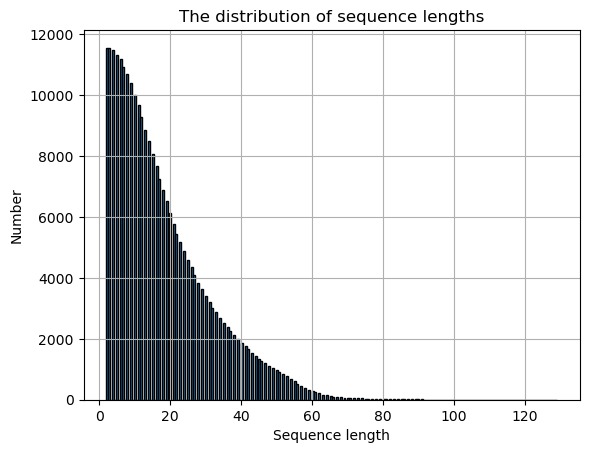

In [15]:
sequence_lengths = [len(x) for x in input_sequences]

sequence_lengths

plt.hist(sequence_lengths, bins='auto', edgecolor='black')
plt.title('The distribution of sequence lengths')
plt.xlabel('Sequence length')
plt.ylabel('Number')
plt.grid(True)
plt.show()

In [16]:
input_sequences = []
for line in filtered_tweets['tweet']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        if len(n_gram_sequence) <= 50:
            input_sequences.append(n_gram_sequence)

print("Total input sequences: ", len(input_sequences))

Total input sequences:  261556


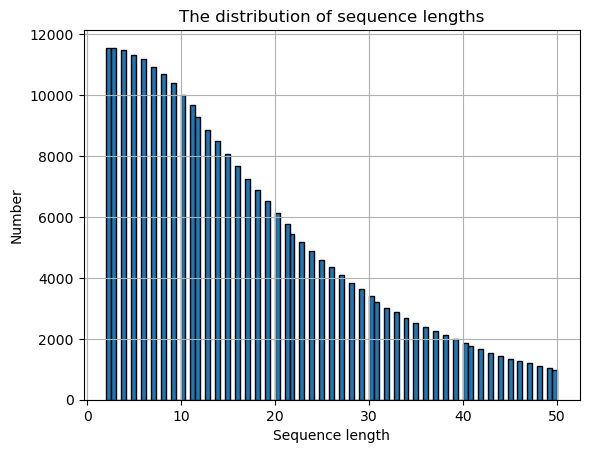

In [17]:
sequence_lengths = [len(x) for x in input_sequences]

sequence_lengths

plt.hist(sequence_lengths, bins='auto', edgecolor='black')
plt.title('The distribution of sequence lengths')
plt.xlabel('Sequence length')
plt.ylabel('Number')
plt.grid(True)
plt.show()

In [18]:
# We standardize the length of the sequences to 50 elements.
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,  10, 112])

In [19]:
# Splitting the sequence into a set of words and the target
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [20]:
print(xs[5])
print(labels[5])
print(ys[5][14])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0   10  112  399   34  842 3483]
217
0.0


Through trial and error, an appropriate architecture was selected for the discussed problem. It was decided to use a bidirectional LSTM layer at the beginning of the model, followed by a Dropout layer to enhance regularization capabilities. The choice of the bidirectional LSTM layer was the result of analyzing other projects related to building word-level LSTM models. The model then included two unidirectional LSTM layers and an additional Dropout layer.

In [21]:
from tensorflow.keras.callbacks import Callback

class ModelCheckpointPerEpoch(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Save the model with a dynamic filename based on the epoch number
        filename = f'my_model_epoch_{epoch+1}.keras'
        self.model.save(filename)
        print(f'\nModel saved as {filename} at the end of epoch {epoch+1}')

# Define your model
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=256, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.3)) 
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))  
model.add(LSTM(256))
model.add(Dense(total_words, activation='softmax'))

adam = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Add the custom callback
checkpoint_callback = ModelCheckpointPerEpoch()

# Fit the model and save after each epoch
history = model.fit(xs, ys, epochs=10, batch_size=64, verbose=1, callbacks=[checkpoint_callback])


C:\Users\franc\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
4087/4087 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.0877 - loss: 6.0728
Model saved as my_model_epoch_1.keras at the end of epoch 1
4087/4087 ━━━━━━━━━━━━━━━━━━━━ 1547s 375ms/step - accuracy: 0.0877 - loss: 6.0727
Epoch 2/10
4087/4087 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.1726 - loss: 5.1215
Model saved as my_model_epoch_2.keras at the end of epoch 2
4087/4087 ━━━━━━━━━━━━━━━━━━━━ 1508s 369ms/step - accuracy: 0.1726 - loss: 5.1215
Epoch 3/10
4087/4087 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.2001 - loss: 4.7365
Model saved as my_model_epoch_3.keras at the end of epoch 3
4087/4087 ━━━━━━━━━━━━━━━━━━━━ 1531s 375ms/step - accuracy: 0.2001 - loss: 4.7365
Epoch 4/10
4087/4087 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.2219 - loss: 4.4541
Model saved as my_model_epoch_4.keras at the end of epoch 4
4087/4087 ━━━━━━━━━━━━━━━━━━━━ 2056s 503ms/step - accuracy: 0.2219 - loss: 4.4541
Epoch 5/10
4087/4087 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2406 

In [ ]:
model = load_model('my_model.keras')
adam = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(xs, ys, epochs=1, batch_size=16, verbose=1)
model.save('my_model.keras')

In [ ]:
model = load_model('my_model.keras')
adam = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#history = model.fit(xs, ys, epochs=1, batch_size=64, verbose=1)
#model.save('my_model.keras')

Since the goal of our model is not to build an effective classifier but a text-generating model, we did not create a validation or test set. The effectiveness of the built models and their ability to generalize were assessed empirically.

### Processing the Generated Text

In the next part, several functions were prepared to transform the generated word sequences into a tweet structure. The generate_text function allows for the generation of sequences of elements, which are then processed into sentence structures.

To enable the generation of diverse tweets based on a starting word, the selection of a word from the model's output layer was modified. Instead of choosing the word with the highest probability of occurrence, 20 words with the highest probabilities are selected, and a word is randomly drawn from these based on their corresponding weights. Without this mechanism, the same sequence of words would always be generated for a given starting word.

Each invocation of the function will allow for the generation of a sequence of elements that will serve as the basis for the next tweet.

In [22]:
def generate_text(seed_text, next_words):
    word_sequence = [seed_text]

    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        
        predicted_probs = model.predict(token_list, verbose=0)
        
        top_indices = np.argsort(predicted_probs[0])[-20:]  # Indices of top 20 highest probabilities
        top_probabilities = predicted_probs[0][top_indices]
        top_probabilities = top_probabilities / np.sum(top_probabilities)
        predicted_index = np.random.choice(top_indices, p=top_probabilities)
        
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        
        word_sequence.append(output_word)
        seed_text += " " + output_word
    
    return word_sequence

#Uruchomienie funkcji
word_sequence = generate_text(seed_text = "boris", next_words = 50)
word_sequence

['boris',
 'goes',
 'fullstop',
 'fullstop',
 'undemocratic',
 'endoftweet',
 'colon',
 'tories',
 'should',
 'pledge',
 'a',
 'referendum',
 'fullstop',
 'endoftweet',
 'england',
 'has',
 'been',
 'in',
 'the',
 'eu',
 'endoftweet',
 'fullstop',
 'it',
 'is',
 'the',
 'eu',
 'into',
 'a',
 'second',
 'brexit',
 'referendum',
 'website',
 'fullstop',
 'endoftweet',
 'like',
 'me',
 'slowly',
 'fullstop',
 'endoftweet',
 'meps',
 'voted',
 'for',
 'to',
 'say',
 'that',
 'wasn’t',
 'strong',
 'enough',
 'fullstop',
 'endoftweet',
 'meps']

The next function will format the generated sequence elements—recoding words into special characters and adjusting the capitalization if the word is the name of a country, institution, or the name of a well-known British politician.

In [23]:
def format_word_sequence(word_sequence):
    word_sequence_formatted = []
    
    for word in word_sequence:
        if word == 'endoftweet':
            break
        
        word = word.replace("fullstop", ".")
        word = word.replace("comma", ",")
        word = word.replace("semicolon", ";")
        word = word.replace("colon", ":")
        word = word.replace("exclamationmark", "!")
        word = word.replace("questionmark", "?")
        word = word.replace("quote", '"')
        word = word.replace("hashtag", "#")
        word = word.replace("account", "@account")
        
        capitalize_words = ['brexit', 'britain', 'ukraine', 'british', 'tory', 'tories', 'labour', 'russia', 'poland', 'germany', 'ireland', 'boris', 'johnson','keir','starmer', 'sadiq', 'khan']
        if word.lower() in capitalize_words:
            word = word.capitalize()
        
        uppercase_words = ['uk', 'mp', 'eu', 'pm', 'nato']
        if word.lower() in uppercase_words:
            word = word.upper()
        
        if word.lower() == 'mps':
            word = 'MPs'
        
        word_sequence_formatted.append(word)
        
        if word == 'endoftweet':
            break
    
    return word_sequence_formatted

word_sequence_formatted = format_word_sequence(word_sequence)
word_sequence_formatted

['Boris', 'goes', '.', '.', 'undemocratic']

The next function will generate continuous text based on the sequences of words.

In [24]:
def generate_text_from_formatted(word_sequence_formatted):
    text = ''
    
    for i in range(len(word_sequence_formatted)):
        if (i == 0) and (not word_sequence_formatted[i].isupper()):
            word_sequence_formatted[i] = word_sequence_formatted[i].capitalize()
        
        if i != 0 and (word_sequence_formatted[i-1] in [".", "?", "!", ";"]):
            word_sequence_formatted[i] = word_sequence_formatted[i].capitalize()
        
        if i != 0 and (word_sequence_formatted[i] in [".", "?", "!", ",", ":"]):
            text += word_sequence_formatted[i]
        else:
            text += ' ' + word_sequence_formatted[i]
    
    return text.strip()  # Strip leading and trailing whitespace

generated_text = generate_text_from_formatted(word_sequence_formatted)
generated_text

'Boris goes.. Undemocratic'

The above example demonstrates that we have successfully built a model that generates incoherent sentences, which, however, maintain some sense. The constructed model is based on initiating words. For this reason, a function has been prepared that passes one of the 50 most popular words in the database as an initiating word to the model (with the probability based on the frequency of that word). This function will be one of the components of the final function.

In [25]:
first_words = filtered_tweets['tweet'].str.split().str[0]
first_word_freq = Counter(first_words)
most_common_first_words = first_word_freq.most_common()

top_n = 10
top_10_words = most_common_first_words[:top_n]

total_freq = sum(freq for word, freq in top_10_words)

words, frequencies = zip(*top_10_words)
probabilities = [freq / total_freq for freq in frequencies]

def get_random_word_based_on_distribution(words, probabilities):
    return random.choices(words, weights=probabilities, k=1)[0]

random_word = get_random_word_based_on_distribution(words, probabilities)
top_10_words

[('account', 7741),
 ('semicolon', 274),
 ('the', 259),
 ('i', 119),
 ('brexit', 88),
 ('this', 65),
 ('if', 61),
 ('we', 61),
 ('eu', 57),
 ('boris', 55)]

The final function, composed of the previous functions, is built below.

In [26]:
def tweet():
    tweet = generate_text_from_formatted(format_word_sequence(generate_text(seed_text = get_random_word_based_on_distribution(words, probabilities), next_words = 50)))
    return tweet

### Summary

It was checked how the generated tweets look.

In [27]:
for i in range(0,10):
    print(tweet() + '\n')

@account you need to be the problem with the UK, i have just been able to offer their own food chamber

@account @account the EU is funding putin's war machine.

@account @account he is not very popular.... .and i voted leave here as an 80 seat majority

@account Brexit is working for British workers, we are not in the EU. The EU is taking more sanctions since the rest of Ukraine Germany has been paying for the UK... .and it is why.

@account we don't have a vote, we are not in the EU, we are still buying russian gas and funding putins war.

@account i agree.

@account he is a disgrace

@account Brexit is working for British workers. Boris is a lot. The EU is leading in the EU. They are in fact that it doesn't matter that it was the right to choose.

@account you would be in the EU, where would they vote?

@account @account i would see him. The EU is funding the russian army as they don't like Germany, the un EU, NATO has never got a country.



The completed project demonstrates that it is difficult to apply LSTM networks for generating coherent text. The generated tweets have poor syntax and lack informational value. The project suggests that a better solution might be to use transformer architecture or an LLM for generating coherent content.